In [0]:
import numpy as np
from plotnine import *
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import DataFrame
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.datasets import make_gaussian_quantiles

# AdaBoost Implementaion

In [0]:
samples_weights = []
stumps_weights = []
strong_learner_err = []

# hold weak learners
stumps = []     

# weak learneres errors
errors = []     

def fit(X, y, iters):
    global samples_weights, stumps, stumps_weights, errors, strong_learner_err
    
    # sample size
    m = len(y)
    
    # initilize arrays
    samples_weights = np.zeros(shape=(iters + 1, m))
    stumps = np.zeros(shape=iters, dtype=object)
    stumps_weights = np.zeros(shape=iters)
    errors = np.zeros(shape=iters)
    strong_learner_err = np.zeros(shape=iters)
    
    # initialize weights (for 0's iteration) uniformly
    samples_weights[0] = np.ones(shape=m) / m
    
    for t in range(iters):
        
        # fit  weak learner
        curr_samples_weights = samples_weights[t]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(X, y, sample_weight=curr_samples_weights)

        # calculate error and stump weight from weak learner prediction
        stump_pred = stump.predict(X)
        err = curr_samples_weights[(stump_pred != y)].sum()
        stump_weight = np.log((1 - err) / err) / 2

        # update sample weights
        new_samples_weights = curr_samples_weights * np.exp(-stump_weight * y * stump_pred)
        new_samples_weights /= new_samples_weights.sum()

        # update sample weights for t+1
        samples_weights[t+1] = new_samples_weights

        # save results of iteration
        stumps[t] = stump
        stumps_weights[t] = stump_weight
        errors[t] = err
        strong_learner_err[t]  = np.mean(predict(X,t)!=y)

        
# predict X after the model is already fitted
# *Call only if predict() was already called*
def predict(X, T):
    prediction = np.zeros(shape = (len(X))) 
    for i in range(T):
        if(stumps[i] != 0):
            prediction += stumps_weights[i] * stumps[i].predict(X)
    return np.sign(prediction)

# AdaBoost Example - 2D 

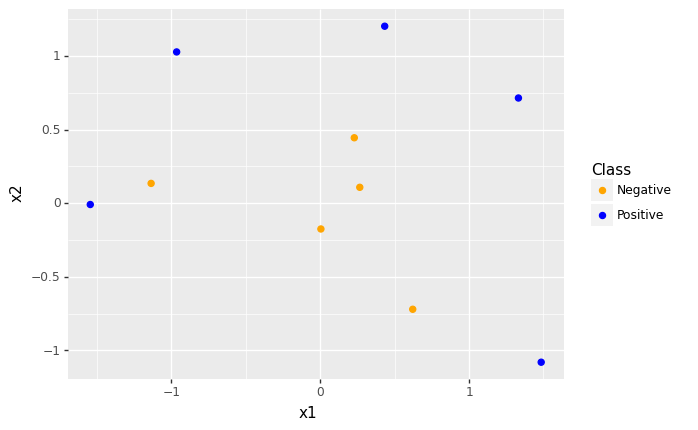

<ggplot: (-9223363270422303579)>

In [18]:
n = 10
np.random.seed(10)

n_per_class = int(n/2)
X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2) 
y = y*2-1

p = (ggplot(DataFrame({'x1' :X[:,0], 'x2': X[:,1],'class':(y==1)}), aes(x='x1', y='x2', color='class')) +
 geom_point(size=2) + 
 labs(title="", color="Class") + 
 scale_color_manual(values=["orange", "blue"], labels=["Negative", "Positive"]))
p

In [0]:
def get_classification_groups(y, y_pred):
    y, y_pred = y.astype(bool), y_pred.astype(bool)

    group = np.repeat('  ', len(y))
    group[np.where(y  &  y_pred)] = "TP"
    group[np.where(y  & ~y_pred)] = "FN"
    group[np.where(~y &  y_pred)] = "FP"
    group[np.where(~y & ~y_pred)] = "TN"
    return group, np.isin(group, ["TP", "TN"])
    
    
def fit_ada(x, y, iters, calc_partitioning=True):
    # We begin with fitting a classification tree to out training set, and evaluating success
    fit(x, y, iters)
    y_pred = (predict(x, iters)==1)
    y = (y==1)
    
    weights = samples_weights[iters]
    
    # weights quantization
    for i in np.linspace(0.9,0 , 10):
        weights[(weights>i) & (weights <i + 0.1)] = i + 0.05
    weights = np.around(weights, decimals=2)
    
    group, correct_class = get_classification_groups(y, y_pred)
    df = DataFrame({'x1':x[:,0], 'x2':x[:, 1], 'class':y, 'pred': y_pred, '~Weight': weights,
                    'correct': correct_class, 'group': group, 'set': 'Train', 'iters': 'T = ' + str(iters)})
    
    if not calc_partitioning:
        return  df
    
    # Later, for visualization, we would like to see the different partitions the classification tree
    # created. For that we create a 2D grid uniformly spread over R^2 of points. There points are to 
    # be classified by the fitted tree, and will be used to show the decision boundaries
    margin = 1.5
    x1_grid, x2_grid = np.meshgrid(np.linspace(x[:, 0].min() - margin, x[:, 0].max() + margin, 100),
                                   np.linspace(x[:, 1].min() - margin, x[:, 1].max() + margin, 100))
    partitioning = np.c_[x1_grid.ravel(), x2_grid.ravel()]
    partitioning_class = predict(partitioning, iters) ==1
       
    df = pd.concat([df, DataFrame({'x1': partitioning[:, 0], 'x2': partitioning[:, 1], 'class': partitioning_class,
                                  'pred': [None]*len(partitioning), 'correct': [None]*len(partitioning), 
                                  'group': [None]*len(partitioning), 'set': 'Partition', 'iters': 'T = ' + str(iters), 
                                   '~Weight':[None] * len(partitioning)})])
    return df

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale_size.py:50: PlotnineWarning: Using alpha for a discrete variable is not advised.
  PlotnineWarning


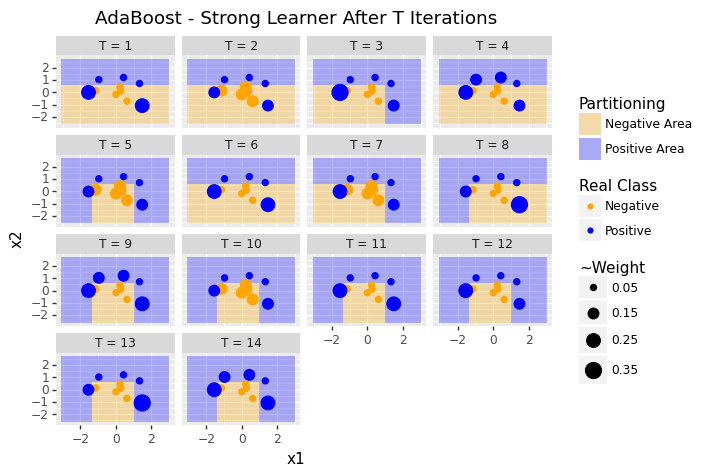

<ggplot: (8766432406455)>

In [15]:
iters = range(1,15)
df = pd.concat([fit_ada(X, y, iters) for iters in iters])
titles = ["T = " + str(T) for T in iters]

df['iters'] = pd.Categorical(df['iters'], 
                            ordered=True,
                            categories=titles)

(ggplot(df[df.set == "Train"], aes(x="x1", y="x2")) +
 geom_tile(df[df.set == "Partition"], aes(fill="class"), alpha=.3) + 
 geom_point(aes(color='class', size = '~Weight')) +
 labs(title="AdaBoost - Strong Learner After T Iterations", color="Real Class", fill="Partitioning") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]) + 
 scale_color_manual(values=["orange", "blue"],  labels=["Negative", "Positive"])+ 
 facet_wrap("iters"))

# Training AdaBoost and Bootstrap

In [0]:
mnist = tf.keras.datasets.mnist

In [0]:
def get_2_labels(first_digit, second_digit):
    (x_train, y_train),(x_test, y_test) = mnist.load_data()

    x_train = (x_train / 255.0 * 2 - 1).reshape(x_train.shape[0], -1)
    x_test = (x_test / 255.0 * 2 - 1).reshape(x_test.shape[0], -1)
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)

    train_images = np.logical_or((y_train == first_digit), (y_train == second_digit))
    test_images = np.logical_or((y_test == first_digit), (y_test == second_digit))
    return x_train[train_images,:], y_train[train_images], x_test[test_images,:], y_test[test_images]


first_label = 8
second_label = 9
x_train, yy_train, x_test, yy_test = get_2_labels(first_label, second_label)

###########################
# change classes to -1,1
###########################
y_train = np.ones(shape = len(yy_train))
y_train[yy_train == first_label] = -1
y_test=np.ones(shape = len(yy_test))
y_test[yy_test == first_label] = -1


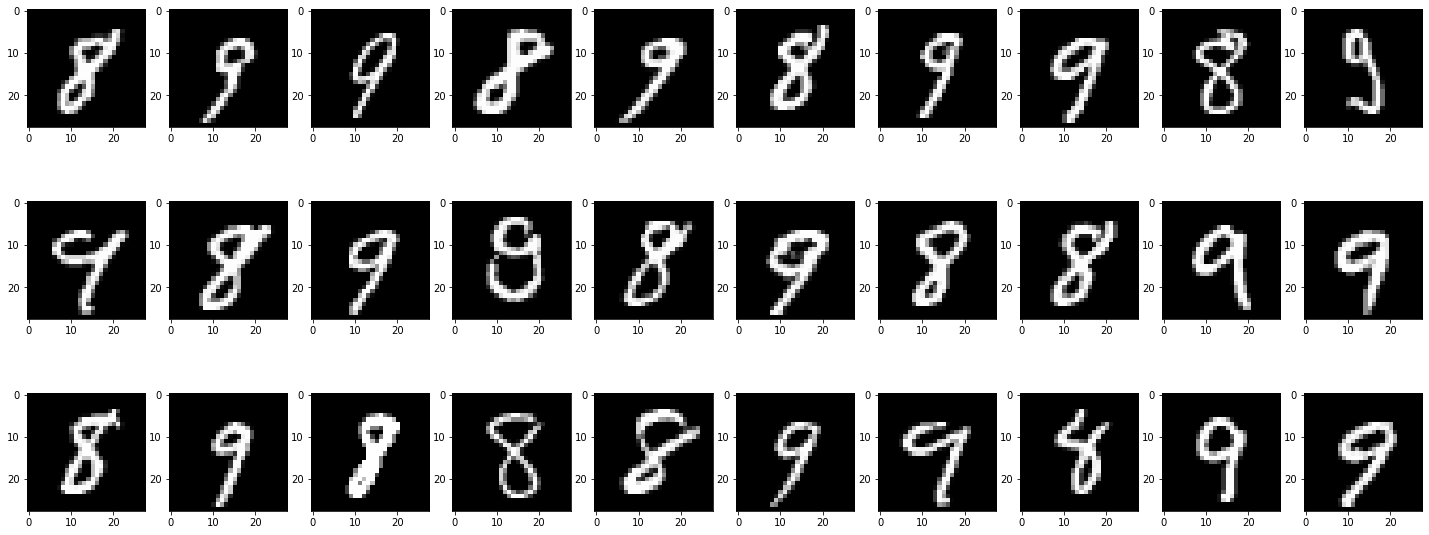

In [22]:
plt.figure(figsize=(25,10))
for i in range(1, 31):
    ax = plt.subplot(3, 10, i) 
    ax.imshow(x_train[i].reshape(28,28), cmap=plt.cm.gray)

In [0]:
iterations = [1, 5, 10, 20, 35, 50]  # number of weak learners

def train_adaboost():
    train_errors = []
    test_errors = []
    train_var = []
    test_var = []
    
    max_interations = iterations[-1]
    fit(x_train, y_train, max_interations)
    
    for T in iterations: 
        train_pred = predict(x_train, T)
        test_pred = predict(x_test, T)
        test_errors.append(1 - np.mean(test_pred == y_test))
        train_errors.append(1 - np.mean(train_pred == y_train))
        train_var.append(train_pred.var())
        test_var.append(test_pred.var())

    return train_errors, test_errors, train_var, test_var



def train_bootstrap():
    all_indexes = np.arange(len(x_train))
    train_errors = []
    test_errors = []
    train_var = []
    test_var = []
    
    max_interations = iterations[-1]
    stumps = np.zeros(shape = max_interations, dtype=object)
        
    for t in range(max_interations):
        # resample new dataset(with replacement)
        indexes = resample(all_indexes, replace = True, n_samples = len(x_train)//100)

        new_x_train, new_y_train = x_train[indexes], y_train[indexes]

        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(new_x_train, new_y_train)
        stumps[t] = stump
    
    for T in iterations:
        # predicting with weak leaners (stumps)
        train_pred = np.sign(np.sum([stumps[t].predict(x_train) for t in range(T)], axis = 0))
        train_errors.append (1 - np.mean(train_pred == y_train))
        train_var.append(train_pred.var())
        
        test_pred = np.sign(np.sum([stumps[t].predict(x_test) for t in range(T)], axis = 0))
        test_errors.append (1 - np.mean(test_pred == y_test))
        test_var.append(test_pred.var())
    
    return train_errors, test_errors, train_var, test_var

In [24]:
%%time

ada_train_error, ada_test_error, ada_train_var, ada_test_var = train_adaboost()
boot_train_error, boot_test_error, boot_train_var, boot_test_var = train_bootstrap()

CPU times: user 49.5 s, sys: 97 ms, total: 49.6 s
Wall time: 49.9 s


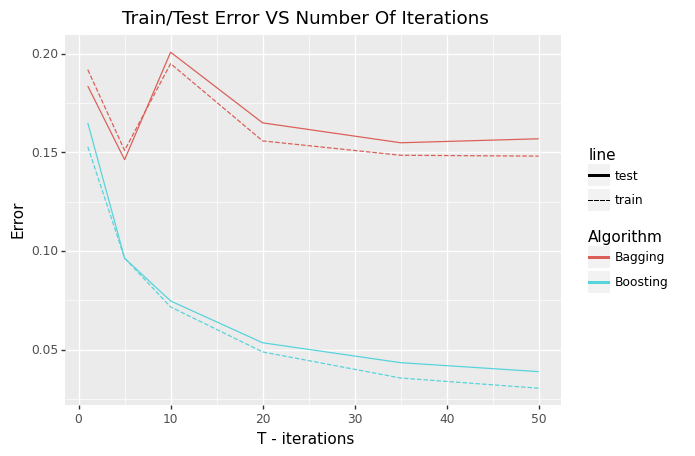

<ggplot: (8766432636059)>

In [25]:
df = DataFrame({'T':iterations, 'error':ada_test_error, 'class':'Boosting', 'set':'test', 'line':'solid'})
df = pd.concat([df,DataFrame({'T':iterations, 'error':boot_test_error, 'class':'Bagging', 'set':'test', 'line':'solid'})])
df = pd.concat([df,DataFrame({'T':iterations, 'error': ada_train_error, 'class':'Boosting', 'set':'train', 'line':'dashed'})])
df = pd.concat([df,DataFrame({'T':iterations, 'error': boot_train_error, 'class':'Bagging', 'set':'train', 'line':'dashed'})])


(ggplot() +
 geom_line(aes(x='T', y='error', color= 'class', linetype = 'line'), data=df[df.set=='test'],  size=0.5) +
  geom_line(aes(x='T', y='error', color= 'class', linetype = 'line'), data=df[df.set=='train'],  size=0.5) +
 scale_linetype_manual(values = ['solid', 'dashed'] , labels = ['test', 'train'])+
 labs(x="T - iterations", y="Error", title="Train/Test Error VS Number Of Iterations", color="Algorithm"))

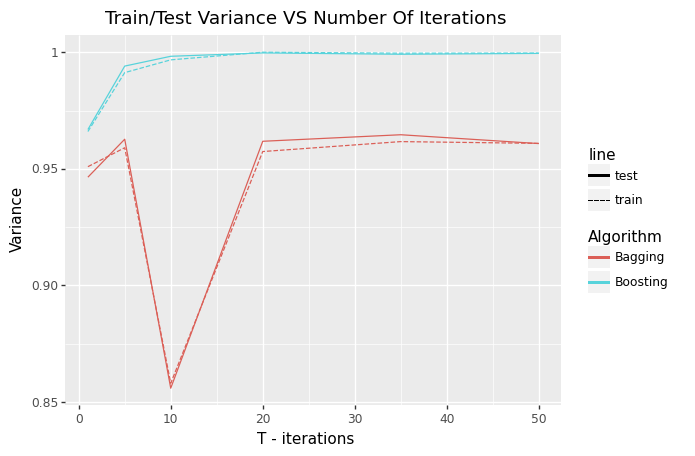

<ggplot: (8766432556969)>

In [26]:
df = DataFrame({'T':iterations, 'variance':ada_test_var, 'class':'Boosting', 'set':'test', 'line':'solid'})
df = pd.concat([df,DataFrame({'T':iterations, 'variance': boot_test_var, 'class':'Bagging', 'set':'test', 'line':'solid'})])
df = pd.concat([df,DataFrame({'T':iterations, 'variance': ada_train_var, 'class':'Boosting', 'set':'train', 'line':'dashed'})])
df = pd.concat([df,DataFrame({'T':iterations, 'variance': boot_train_var, 'class':'Bagging', 'set':'train', 'line':'dashed'})])


(ggplot() +
 geom_line(aes(x='T', y='variance', color= 'class', linetype = 'line'), data=df[df.set=='test'],  size=0.5) +
  geom_line(aes(x='T', y='variance', color= 'class', linetype = 'line'), data=df[df.set=='train'],  size=0.5) +
 scale_linetype_manual(values = ['solid', 'dashed'] , labels = ['test', 'train'])+
 labs(x="T - iterations", y="Variance", title="Train/Test Variance VS Number Of Iterations", color="Algorithm"))
